In [6]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.spatial import Delaunay


from igraph import *
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import random

In [7]:
directory = os.path.abspath("uber_data/")

graph_data = pd.read_csv(directory + '/san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv')
graph_data = graph_data.drop(['standard_deviation_travel_time', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'], axis=1)
graph_data = graph_data.drop(graph_data[graph_data.month != 12].index)
dec_data = graph_data.drop(['month'], axis=1)

In [8]:
# Remove duplicates and keep the mean of duplicate travel times# Remove  
dec_array = np.asarray(dec_data) # idk numpy seems easier to work with
existing_paths = {}
existing_locations = np.unique(np.concatenate([dec_array[:,0],dec_array[:,1]]))
counter = 0
for row in dec_array:
    locations = tuple(np.sort(row[0:2]))
    if locations in existing_paths:
        existing_paths[locations].append(row[2])
        counter += 1
    else:
        existing_paths[locations] = [row[2]]

In [9]:
# Write out a csv file with december data, where duplicates are averaged
# This will be used in R's igraph library to do graph analysis
with open(directory + '/december_data.txt','w') as f:
    for locations in existing_paths:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),np.mean(existing_paths[locations]))
        f.write(string)

In [11]:
# Load in the location data
with open(directory + '/san_francisco_censustracts.json') as json_data:
    geo_data = json.load(json_data)
geo_data = geo_data['features']

In [12]:
# Process the raw data into a dictionary where key is location ID, value is display name and coordinate list
location_dictionary = {}

for entry in geo_data:
    data = {}
    # Retrieve coordinate list and compute mean coordinates
    coord_list = entry['geometry']['coordinates'][0][0]
    mean_coord = np.mean(np.asarray(coord_list),axis=0)
    movement_id = entry['properties']['MOVEMENT_ID']

    data['coord_list'] = coord_list
    data['mean_coord'] = mean_coord
    data['display_name'] = entry['properties']['DISPLAY_NAME']
    location_dictionary[movement_id] = data

In [15]:
uber_graph = Graph.Read(directory + '/december_data.txt', format='ncol', directed=False)

gcc = uber_graph.components().giant()
summary(gcc)
summary(uber_graph)

print("We can see 7 nodes were removed")


# write graph to file
Graph.write_ncol(gcc, directory + '/uber_gcc.txt')

IGRAPH UNW- 1898 321703 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 1905 321713 -- 
+ attr: name (v), weight (e)
We can see 7 nodes were removed


In [17]:
# QUESTION 7: Build a minimum spanning tree (MST) of graph G. Report the street addresses
# of the two endpoints of a few edges. Are the results intuitive?

# edges in mst should be relatively shorter.

mst = gcc.spanning_tree(weights = gcc.es["weight"])
vertices = mst.vs()
summary(mst)

print('-'*50)

rand_n = []
for x in range(3):
    rand_n.append(random.randint(0,len(mst.es())-1))

count = 0
rand_e = []
for e in mst.es():
    st = e.tuple
    if count < 10:
        print(location_dictionary[vertices[st[0]]['name']]['display_name'],'---',location_dictionary[vertices[st[1]]['name']]['display_name'])
    
    if count in rand_n:
        rand_e.append(location_dictionary[vertices[st[0]]['name']]['display_name'])
        rand_e.append(location_dictionary[vertices[st[1]]['name']]['display_name'])
    count += 1
#     print(location_dictionary[str(st[0])]['display_name'], '---', location_dictionary[str(st[1])]['display_name'])

IGRAPH UNW- 1898 1897 -- 
+ attr: name (v), weight (e)
--------------------------------------------------
700 Lakeville Circle, Petaluma --- 7700 Lakeville Highway, Petaluma
200 Ely Road North, Petaluma --- 2600 Goodwin Avenue, Penngrove
Interstate 505, Vacaville --- Sikes Road, Dixon
3800 Mission Drive, Santa Cruz --- 1200 Rodriguez Street, Santa Cruz
19200 San Ramon Valley Boulevard, San Ramon --- 0 Mesa Vista Court, San Ramon
11600 Bruceville Road, Elk Grove --- 600 Vorden Road, Walnut Grove
2100 Canoas Garden Avenue, South San Jose, San Jose --- 2000 Little Orchard Street, South San Jose, San Jose
3500 Hicks Valley Road, Novato --- 0 Black Oak Lane, Novato
13700 Westboro Drive, Alum Rock, San Jose --- 500 Massar Avenue, East San Jose, San Jose
1000 Sterling Avenue, Berkeley Hills, Berkeley --- 1400 Queens Road, Berkeley Hills, Berkeley


In [16]:
# QUESTION 11: Plot the road mesh 

# Load the cleaned graph data in
uber_gcc = np.loadtxt(directory + '/uber_gcc.txt')
uber_gcc_graph = {}
for row in uber_gcc:
    location_index = tuple(np.sort(row[0:2]).astype('int'))
    uber_gcc_graph[location_index] = row[2]

In [18]:
uber_gcc_ids = np.concatenate([uber_gcc[:,0],uber_gcc[:,1]])
uber_gcc_ids = np.unique(uber_gcc_ids).astype('int')

mean_coords = np.zeros((len(uber_gcc_ids),2))
for n,location_key in enumerate(uber_gcc_ids):
    mean_coords[n,:] = location_dictionary[str(location_key)]['mean_coord']

In [19]:
tri = Delaunay(mean_coords)

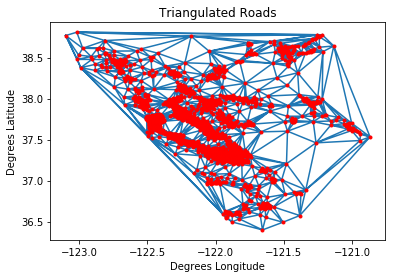

In [20]:
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads')
plt.show()

In [21]:
# Question 13:

# Generate a new graph file that can be used in igraph to compute max flow

MILES_PER_DEGREE_LATLON = 69

def get_time(loc1,loc2,transit_time_graph):
    if (loc1,loc2) in transit_time_graph.keys():
        return transit_time_graph[(loc1,loc2)]
    else:
        return 0

# Calculate flow as #cars/hour
def get_flow(loc1, loc2, transit_time_graph,location_dict):
    coord1 = location_dict[str(loc1)]['mean_coord']
    coord2 = location_dict[str(loc2)]['mean_coord']
    distance_miles = MILES_PER_DEGREE_LATLON * np.sqrt(np.sum(np.square(coord2-coord1)))
    if (loc1,loc2) in transit_time_graph.keys():
        travel_time_hours = transit_time_graph[(loc1,loc2)] / 3600
        speed_mph = distance_miles / travel_time_hours
        flow = (2*speed_mph) / (0.003 + (speed_mph/1800))
        return flow
    else:
        return 0


def add_triangulated_edge(graph, triangle):
    edge12 = tuple(np.sort(triangle[:2]))
    edge13 = tuple(np.sort(triangle[0::2]))
    edge23 = tuple(np.sort(triangle[1:]))   

    flow12 = get_flow(edge12[0],edge12[1],uber_gcc_graph,location_dictionary)
    flow13 = get_flow(edge13[0],edge13[1],uber_gcc_graph,location_dictionary)
    flow23 = get_flow(edge23[0],edge23[1],uber_gcc_graph,location_dictionary)
    if edge12 not in graph.keys() and flow12 > 0:
        graph[edge12] = flow12
    if edge13 not in graph.keys() and flow13 > 0:
        graph[edge13] = flow13
    if edge23 not in graph.keys() and flow23 > 0:
        graph[edge23] = flow23

def add_travel_time_edge(graph,triangle,thresh):
    edge12 = tuple(np.sort(triangle[:2]))
    edge13 = tuple(np.sort(triangle[0::2]))
    edge23 = tuple(np.sort(triangle[1:]))   
    
    time12 = get_time(edge12[0],edge12[1],uber_gcc_graph)
    time13 = get_time(edge13[0],edge13[1],uber_gcc_graph)
    time23 = get_time(edge23[0],edge23[1],uber_gcc_graph)
    
    if edge12 not in graph.keys() and time12 < thresh and time12 > 0:
        graph[edge12] = time12
    if edge13 not in graph.keys() and time13 < thresh and time13 > 0:
        graph[edge13] = time13
    if edge23 not in graph.keys() and time23 < thresh and time23 > 0:
        graph[edge23] = time23

In [22]:
triangulated_graph = {}

for triangle_idx in tri.simplices:
    triangle = [uber_gcc_ids[triangle_idx[0]], uber_gcc_ids[triangle_idx[1]], uber_gcc_ids[triangle_idx[2]]]
    add_triangulated_edge(triangulated_graph,triangle)

In [23]:
# Write out a txt file with triangulated data
# This will be used in R's igraph library to do graph analysis
with open(directory + '/triangulated_graph.txt','w') as f:
    for locations in triangulated_graph:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),triangulated_graph[locations])
        f.write(string)

In [24]:
# Locate the IDs for Stanford and UCSC
for i in location_dictionary.keys():
    if location_dictionary[i]['display_name'] == '100 Campus Drive, Stanford':
        print("Stanford ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))
    if location_dictionary[i]['display_name'] == '700 Meder Street, Santa Cruz':
        print("UCSC ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))
    # SF ID = 46

UCSC ID = 1968, [-122.06456181   36.97416881]
Stanford ID = 2607, [-122.17598222   37.42968589]


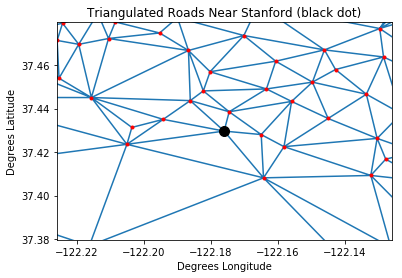

In [25]:
# Q13 
stanford_coords = location_dictionary['2607']['mean_coord']
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((stanford_coords[0]-0.05,stanford_coords[0]+0.05))
plt.ylim((stanford_coords[1]-0.05,stanford_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Near Stanford (black dot)')
plt.show()


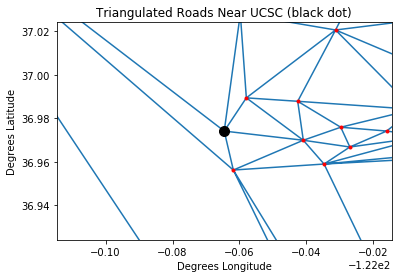

In [26]:
#Q13 Continued
ucsc_coords = location_dictionary['1968']['mean_coord']
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.05,ucsc_coords[0]+0.05))
plt.ylim((ucsc_coords[1]-0.05,ucsc_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Near UCSC (black dot)')
plt.show()

In [84]:
#Q14 Prune the graph
triangulated_time_graph = {}
THRESH = 1300

for triangle_idx in tri.simplices:
    triangle = [uber_gcc_ids[triangle_idx[0]], uber_gcc_ids[triangle_idx[1]], uber_gcc_ids[triangle_idx[2]]]
    add_travel_time_edge(triangulated_time_graph, triangle, THRESH)
    
len(triangulated_time_graph)

5074

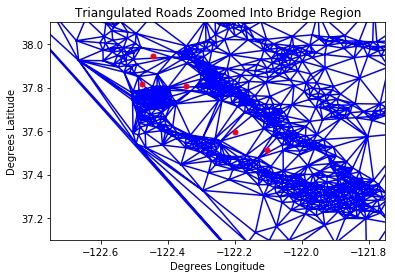

In [87]:
#Q14 Plot the original region near the bay
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy(),color='b')
#plt.plot(mean_coords[:,0], mean_coords[:,1],'b.')
plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))
bridge1 = [(-122.475+-122.479)/2, (37.806+37.83)/2]
bridge2 = [(-122.501+-122.387)/2, (37.956+37.93)/2]
bridge3 = [(-122.273+-122.122)/2, (37.563+37.627)/2]
bridge4 = [(-122.142+-122.067)/2, (37.486+37.54)/2]
bridge5 = [(-122.388+-122.302)/2, (37.788+37.825)/2]

bridges = np.array([bridge1,bridge2,bridge3,bridge4,bridge5])
plt.plot(bridges[:,0],bridges[:,1],'r.',ms=10)
#plt.show()
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Zoomed Into Bridge Region')
plt.show()


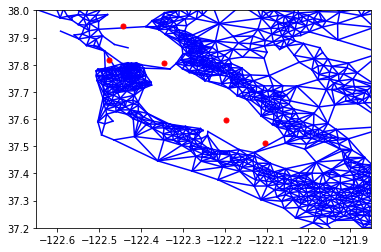

In [85]:
#Q15 Plot the pruned graph

plt.figure()
counter = 0
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.ylim((37.6-0.4,37.6+0.4))
plt.xlim((-122.25-0.4,-122.25+0.4))

bridge1 = [(-122.475+-122.479)/2, (37.806+37.83)/2]
bridge2 = [(-122.501+-122.387)/2, (37.956+37.93)/2]
bridge3 = [(-122.273+-122.122)/2, (37.563+37.627)/2]
bridge4 = [(-122.142+-122.067)/2, (37.486+37.54)/2]
bridge5 = [(-122.388+-122.302)/2, (37.788+37.825)/2]

bridges = np.array([bridge1,bridge2,bridge3,bridge4,bridge5])
plt.plot(bridges[:,0],bridges[:,1],'r.',ms=10)
plt.show()

In [88]:
#Q15 - Generate the pruned graph as a text file to be read into R
with open(directory + '/pruned_triangulated_graph.txt','w') as f:
    for loc_pairs in triangulated_time_graph.keys():
        flow = get_flow(loc_pairs[0],loc_pairs[1], uber_gcc_graph, location_dictionary)
        if flow > 0:
            string = '{} {} {:.2f}\n'.format(int(loc_pairs[0]),int(loc_pairs[1]),flow)
            f.write(string)

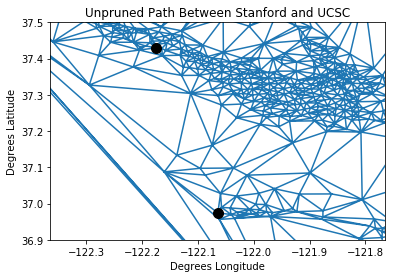

In [31]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.3,ucsc_coords[0]+0.3))
plt.ylim((37.2-0.3,37.2+0.3))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Unpruned Path Between Stanford and UCSC')
plt.show()

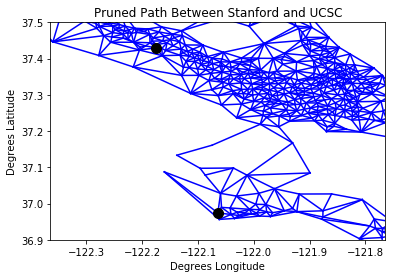

In [32]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.3,ucsc_coords[0]+0.3))
plt.ylim((37.2-0.3,37.2+0.3))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path Between Stanford and UCSC')
plt.show()

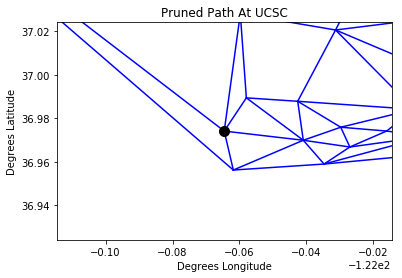

In [33]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.05,ucsc_coords[0]+0.05))
plt.ylim((ucsc_coords[1]-0.05,ucsc_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path At UCSC')
plt.show()

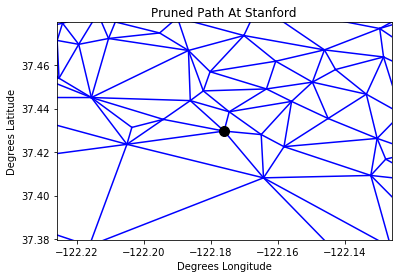

In [34]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((stanford_coords[0]-0.05,stanford_coords[0]+0.05))
plt.ylim((stanford_coords[1]-0.05,stanford_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path At Stanford')
plt.show()